## Setup and Import

In [263]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 10)

In [264]:
# export
import cv2
import time

In [265]:
# export 
import os, sys
# base = "/Users/ckh/Documents/Poladrone/nb"
base = "D:/YoloV5_Hui/poladrone_nb"
sys.path.append(base + "/ref/pytorchYOLOv4")

In [266]:
# export 
from exp.nb_TrainingRunnner import *
from exp.nb_LoggingModule import custom_init_logger
from config.config import Cfg

from ref.pytorchYOLOv4.tool.utils import nms_cpu, bbox_iou

## Evaluation

### Load Data

In [267]:
# data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/train_npt.txt"
data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/npt_test.txt"
# data_list = "D:/YoloV5_Hui/Dataset/train_npt.txt"
val_dataset = Detection_dataset(data_list, Cfg, val=True, val_keep_size=True)


### Load Model

In [268]:
# export 
def load_model(weight_path, n_classes=1):
    ## load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Load: {weight_path} | Device: {device}')
    
    model = Yolov4(None, n_classes=n_classes, inference=True)
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    return model


In [269]:
model_path = "./weight/Yolov4_epoch1707.pth"
model = load_model(model_path)

Load: ./weight/Yolov4_epoch1707.pth | Device: cpu


## Function

### Preprocessing

In [270]:
# export 
def preprocess_image(img_raw, targetSize=416):
    img = cv2.resize(img_raw, (targetSize,targetSize))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).div(255.0)
    img = img.unsqueeze(0)
    return img

### Inferencing

In [272]:
# export 
def predict_img(model, img, size):
    img = preprocess_image(img, targetSize=size)
    out = model(img)
    return out

In [273]:
# !mkdir inference

def inference_index(index, size, postfix="", show=False, save=False):
    img_raw, gt = val_dataset[index]
    out = predict_img(model, img_raw, size)
    if show:
        out_img = visualize_yolo(img_raw, out, gt=gt, targetSize=size, conf_thresh=0.01)
    if save:
        cv2.imwrite("./inference/%d%s.jpg"%(index, postfix), out_img)
    return out

### Post processing

In [274]:
# export 
def post_processing(img, conf_thresh, nms_thresh, output):

    # anchors = [12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]
    # num_anchors = 9
    # anchor_masks = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    # strides = [8, 16, 32]
    # anchor_step = len(anchors) // num_anchors

#     t1 = time.time()

    if type(output).__name__ != 'ndarray':
        output = output.cpu().detach().numpy()

    # [batch, num, 4]
    box_array = output[:, :, :4]

    # [batch, num, num_classes]
    confs = output[:, :, 4:]

    # [batch, num, num_classes] --> [batch, num]
    max_conf = np.max(confs, axis=2)
    max_id = np.argmax(confs, axis=2)

#     t2 = time.time()

    bboxes_batch = []
    for i in range(box_array.shape[0]):
       
        argwhere = max_conf[i] > conf_thresh
        l_box_array = box_array[i, argwhere, :]
        l_max_conf = max_conf[i, argwhere]
        l_max_id = max_id[i, argwhere]

        keep = nms_cpu(l_box_array, l_max_conf, nms_thresh)
        
        bboxes = []
        if (keep.size > 0):
            l_box_array = l_box_array[keep, :]
            l_max_conf = l_max_conf[keep]
            l_max_id = l_max_id[keep]

            for j in range(l_box_array.shape[0]):
                bboxes.append([l_box_array[j, 0], l_box_array[j, 1], l_box_array[j, 2], l_box_array[j, 3], l_max_conf[j], l_max_conf[j], l_max_id[j]])
        
        bboxes_batch.append(bboxes)

#     t3 = time.time()

#     print('-----------------------------------')
#     print('       max and argmax : %f' % (t2 - t1))
#     print('                  nms : %f' % (t3 - t2))
#     print('Post processing total : %f' % (t3 - t1))
#     print('-----------------------------------')
    
    return bboxes_batch


### Visualize

In [271]:
def visualize_yolo(img_raw, yolo_out, conf_thresh= 0.5, gt=None, targetSize=1000):
    out = yolo_out
    img = img_raw.copy()
    
    border = 2
    font_size = 1.2
    img = cv2.resize(img, (targetSize,targetSize))
        
    if not out.size == 0:
        out_box = out[out[:,:,4] > conf_thresh]
        bboxes = out_box[:,0:4] * targetSize
        conf = out_box[:,4]
        x,y,w,h = bboxes[:,0], bboxes[:,1], bboxes[:,2]/2, bboxes[:,3]/2

        x1, x2, y1, y2 = x-w, x+w, y-h, y+h

        for b in zip(x1,y1,x2,y2, conf):
            c = b[4]
            b = list(map(int,b))
            cv2.rectangle(img, (b[0],b[1]), (b[2],b[3]), (0,0,255), border)
            text = "NPT %.1f"%(c*100) ##self.id_names[b[4]]
            cv2.putText(img, text, (b[0],b[1]), cv2.FONT_HERSHEY_PLAIN, font_size, (255,0,0), border)
        
    if not gt is None:
        gt_box = gt[:,:4] * (targetSize / img_raw.shape[0])
        for g in gt_box:
            b = list(map(int,g))
            cv2.rectangle(img, (b[0],b[1]), (b[2],b[3]), (0,255,255), border)
            text = "GT" ##self.id_names[b[4]]
            cv2.putText(img, text, (b[2],b[1]), cv2.FONT_HERSHEY_PLAIN, font_size, (0,255,255), border)

    plt.imshow(img)
    
    return img

### Score

In [275]:
# export 
def bbox_iogt(box1, box2, x1y1x2y2=True):
    '''
    box1: GT
    '''
    
    # print('iou box1:', box1)
    # print('iou box2:', box2)

    if x1y1x2y2:
        mx = min(box1[0], box2[0])
        Mx = max(box1[2], box2[2])
        my = min(box1[1], box2[1])
        My = max(box1[3], box2[3])
        w1 = box1[2] - box1[0]
        h1 = box1[3] - box1[1]
        w2 = box2[2] - box2[0]
        h2 = box2[3] - box2[1]
    else:
        w1 = box1[2]
        h1 = box1[3]
        w2 = box2[2]
        h2 = box2[3]

        mx = min(box1[0], box2[0])
        Mx = max(box1[0] + w1, box2[0] + w2)
        my = min(box1[1], box2[1])
        My = max(box1[1] + h1, box2[1] + h2)
    uw = Mx - mx
    uh = My - my
    cw = w1 + w2 - uw
    ch = h1 + h2 - uh
    carea = 0
    if cw <= 0 or ch <= 0:
        return 0.0

    area1 = w1 * h1
    area2 = w2 * h2
    carea = cw * ch
#     uarea = area1 + area2 - carea
    uarea = area1 
    return carea / uarea


In [229]:
# export 
def score(gt, nms):
    if nms.size == 0:
        return 0, len(gt)
        
    box_gt = gt/1000

    x1 = nms[:,:,0] - nms[:,:,2]
    y1 = nms[:,:,1] - nms[:,:,3]
    x2 = nms[:,:,0] + nms[:,:,2]
    y2 = nms[:,:,1] + nms[:,:,3]
    box_predict = np.concatenate([x1,y1,x2,y2], axis=0).T

    iogt = [[bbox_iogt(g, p) for g in box_gt] for p in box_predict]
    iogt = np.max(iogt, axis=0)

    total = len(iogt)
    score = sum(iogt > 0.9)
    
    return score, total

## Predict - Experiment

#### Predict Flow

#### Comparing  input Size

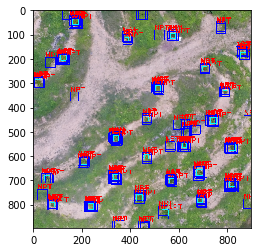

In [47]:
## Try with different size
index = 180
for s in range(0,300,16):
    size = 608+s
    inference_index(index,size=size, postfix="_%d"%(size))

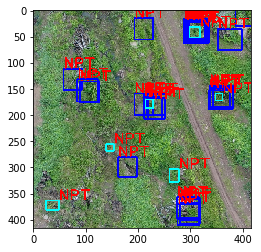

In [25]:
visualize_yolo(img_raw, out, conf_thresh=0.01, gt=gt, targetSize=416)

#### Comparing NMS

In [121]:
## inference
index=180
out = predict_index(index, 720)  

-----------------------------------
       max and argmax : 0.000617
                  nms : 0.002450
Post processing total : 0.003067
-----------------------------------
-----------------------------------
       max and argmax : 0.000255
                  nms : 0.004886
Post processing total : 0.005141
-----------------------------------


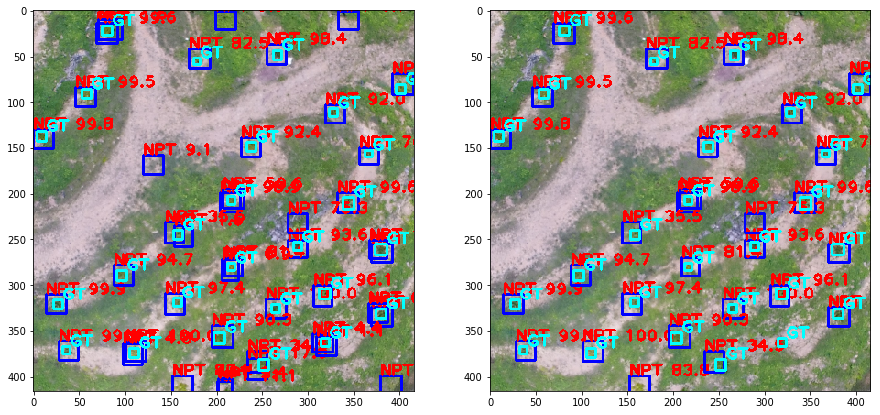

In [128]:
## Comparing NMS
nms_box = post_processing(None, 0.01,0.5, out)
nms = np.array(nms_box)
plt.subplot(121)
out_img = visualize_yolo(val_dataset[index][0], nms, 0, gt=val_dataset[index][1], targetSize=416)

nms_box = post_processing(None, 0.3,0.5, out)
nms = np.array(nms_box)
plt.subplot(122)
out_img = visualize_yolo(val_dataset[index][0], nms, 0, gt=val_dataset[index][1], targetSize=416)

## Evaluation Flow - Main

In [276]:
# export 
def benchmark_size(size):
    
    pt = []
    count = []
    t = []
    for index in range(len(val_dataset)):
        print(index, end=" ")
        ## inference
        img_raw, gt = val_dataset[index]

        t1 = time.time()
        out = predict_img(model, img_raw, size)
        t2 = time.time()
        t.append(t2 - t1)

        ## NMS
        nms_box = post_processing(None, 0.01,0.5, out)
        nms = np.array(nms_box)

        p, c = score(gt, nms)
        pt.append(p)
        count.append(c)

    inference_time = np.mean(t)
    score_pre_img = (np.array(pt) / np.array(count)).mean()
    score_all = np.sum(pt) / np.sum(count)

    return inference_time, score_pre_img, score_all

In [ ]:
data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/npt_test.txt"
# data_list = "D:/YoloV5_Hui/Dataset/train_npt.txt"
val_dataset = Detection_dataset(data_list, Cfg, val=True, val_keep_size=True)

In [ ]:
model_path = "./weight/Yolov4_epoch1707.pth"
model = load_model(model_path)

In [277]:
logging = custom_init_logger("score")
logging_plot = custom_init_logger("plot")

for size in range(320,900,32):
    logging.info(f"Size : {size}")
    time_taken, score_img, score_all = benchmark_size(size)
    logging.info(f"""
                 Time : {time_taken} / image
                 Score per image: {score_img}
                 Score total : {score_all}
                 """)
    logging_plot.info(f"{size},{time_taken},{score_img},{score_all}")

log file path:~/temp/log/score
log file path:~/temp/log/plot
2020-07-16 17:49:52,511 <ipython-input-277-603e9f5e188e>[line:5] INFO: Size : 320
2020-07-16 17:49:52,511 <ipython-input-277-603e9f5e188e>[line:5] INFO: Size : 320
0 1 2 3 4 5 

KeyboardInterrupt: 

## Export

In [278]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "NOTEBOOK = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [279]:
!python notebook2script.py "$NOTEBOOK".ipynb

Converted Evaluation.ipynb to exp/nb_Evaluation.py
